In [1]:
#CNN with Glove embeddings
#load data
import os
mypath="C:/Users/USER/eRisk2017/2017/"
os.chdir( mypath )

In [2]:
import numpy as np
import pandas as pd
train_df=pd.read_csv('train_Depression_all_chunks_nosteem.csv')
train_df=train_df.replace(np.nan, '', regex=True)
test_df=pd.read_csv('test_Depression_all_chunks_nosteem.csv')
test_df=test_df.replace(np.nan, '', regex=True)

C:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
def generate_data(df, nchunks=1):
    # Extract the first chunk of data
    data = df['Chunk_1']
    
    # Rename the column to 'x' (although this line has no effect as it doesn't modify the original DataFrame)
#     data.rename(columns={'Chunk_1': 'x'})
    
    # If nchunks is less than or equal to 1, do nothing
    if nchunks <= 1:
        pass
    else:
        # Iterate over the remaining chunks and concatenate them with the first chunk
        for i in range(2, nchunks):
            chunk = 'Chunk_' + str(i)
            data += df[chunk]
    
    # Return the values of the concatenated data
    return data.values

In [4]:
x_train=generate_data(train_df,10)
y_train=train_df['Depress'].values
x_test=generate_data(test_df,10)
y_test=test_df['Depress'].values

In [5]:
phrase_len=[len(p.split(' ')) for p in  (list(x_train.flatten()))]
max_phrase=max(phrase_len)
max_phrase

49597

(array([292.,  70.,  56.,  28.,  21.,  10.,   1.,   5.,   0.,   3.]),
 array([1.00000e+00, 4.96060e+03, 9.92020e+03, 1.48798e+04, 1.98394e+04,
        2.47990e+04, 2.97586e+04, 3.47182e+04, 3.96778e+04, 4.46374e+04,
        4.95970e+04]),
 <BarContainer object of 10 artists>)

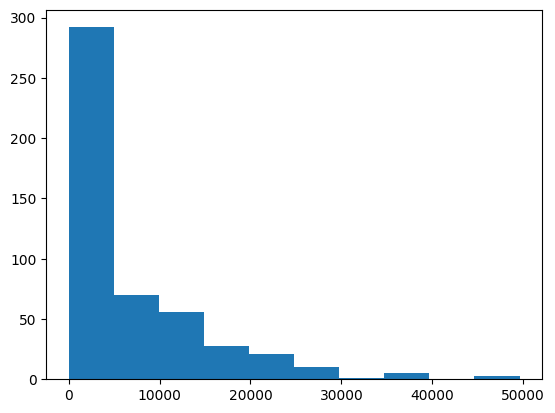

In [6]:
import matplotlib.pyplot as plt
plt.hist(phrase_len,density=False)

In [7]:
j=30000
sum(i>j for i in phrase_len)

9

In [8]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
max_words=10000
max_len= 30000
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
X_train=tokenizer.texts_to_sequences(x_train)
X_train= pad_sequences(X_train,maxlen=max_len)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
from keras import backend as K

In [11]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
model_lstm=Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 50, input_length = max_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(100, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(1, activation = 'sigmoid'))

In [13]:
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy',f1_m,precision_m, recall_m]
)

In [14]:
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30000, 50)         500000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 30000, 50)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 560,501
Trainable params: 560,501
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
epochs=30
batch_size=32
history=model_lstm.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2)

Epoch 1/30
13/13 [==============================] - 12752s 973s/step - loss: 0.6275 - accuracy: 0.7500 - f1_m: 0.0228 - precision_m: 0.0162 - recall_m: 0.0385 - val_loss: 0.1224 - val_accuracy: 1.0000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
13/13 [==============================] - 10041s 781s/step - loss: 0.5280 - accuracy: 0.7861 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.3354 - val_accuracy: 1.0000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/30
13/13 [==============================] - 9951s 773s/step - loss: 0.5065 - accuracy: 0.7861 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.2044 - val_accuracy: 1.0000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/30
13/13 [==============================] - 10139s 788s/step - loss: 0.4782 - accuracy: 0.7861 - f1_m: 0.0000e+00 - precision_